# **<center><font style="color:rgb(100,109,254)">Module 1: Creating a Live Gesture Control Application</font> </center>**


<img src='https://drive.google.com/uc?export=download&id=10xY6U-4CecBuMkbONZp6bPx7BAZB6xfX'>

## **<font style="color:rgb(134,19,348)"> Module Outline </font>**

The module can be split into the following parts:

- *Lesson 1: Introduction to hand landmark detection theory*

- *Lesson 2:* Create a Hands Landmarks Detector

- ***Lesson 3:* Build a Hands Fingers Counter** *(This Tutorial)*

- *Lesson 4:* Build a Hand Gesture Recognizer

- *Lesson 5:* Distance measurement

- *Lesson 6:* Brightness, Saturation, Contrast Enhancement & Gamma Correction

- *Lesson 7:* Build the Final Application

**Please Note**, these Jupyter Notebooks are not for sharing; do read the Copyright message below the Code License Agreement section which is in the last cell of this notebook.
-Taha Anwar

Alright, let's get started.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

First we will import the required libraries.

In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from previous_lesson import detectHandsLandmarks

# Additional comments:
#       - The other parts of the codes are imported
#         from the previous lesson

## **<font style="color:rgb(134,19,348)">Initialize the Hands Landmarks Detection Model</font>**

After that, we will need to initialize the **`mp.solutions.hands`** class and then set up the **`mp.solutions.hands.Hands()`** function with appropriate arguments and also initialize **`mp.solutions.drawing_utils`** class that is required to visualize the detected landmarks, as we had done in the previous lesson. 

In [2]:
# Initialize the mediapipe hands class.
mp_hands = mp.solutions.hands

# Set up the Hands functions for images and videos.
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)
hands_videos = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.8)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils


# Additional comments:
#       - Nothing much has changed from the previous
#         initialization of the mediapipe hands solution
#         and the drawing utils

## **<font style="color:rgb(134,19,348)">Create a Fingers Counter Function</font>**

Now we will create a function **`countFingers()`** that will utilize the results of the landmarks detection returned by the function **`detectHandsLandmarks()`** to count the number of fingers up of each hand in the image/frame and will return the count, the status of each finger, and tip landmark of each finger in the image as well. 

<img src='https://drive.google.com/uc?export=download&id=1_iuJmm7_f2xn3jnq6HmyH47a2_pRoV6J'>

***How will it work?***

To check the status of each finger (i.e., either it is up or not), we will compare the y-coordinates of the `FINGER_TIP` landmark and `FINGER_PIP` landmark of the fingers. For the fingers that are up, the `FINGER_TIP` landmark will have a lower value than the `FINGER_PIP` landmark. 

But for the thumbs, the scenario will be a little different as we will have to compare the x-coordinates of the `THUMB_TIP` landmark and `THUMB_MCP` landmark, and the condition will vary depending upon whether the hand is Left or Right. And to get the hand label i.e. Left or Right, we will utilize the output by the hands landmarks detection that has another attribute **`multi_handedness`** which contains the predicted **`label`** (either `"Left"` or `"Right"`) for each detected hand. 

<img src='https://drive.google.com/uc?export=download&id=1RYQerRsuxqC9e57_SugISP7J5pBHKunI'>

For the right hand, whenever the thumb will be open, the x-coordinate of the `THUMB_TIP` landmark will have a lower value than the `THUMB_MCP` landmark, and for the left hand, the x-coordinate of the `THUMB_TIP` landmark will have a greater value than the `THUMB_MCP` landmark.

**Note:** *You have to face the palm of your hand towards the camera.*

In [15]:
def countFingers(image, results, draw=True, display=True):
    '''
    This function will count the number of fingers up for each hand in the image.
    Args:
        image:   The image of the hands on which the fingers counting is required to be performed.
        results: The output of the hands landmarks detection performed on the image.
        draw:    A boolean value that is if set to true the function writes the total count of 
                 fingers up, of the hands on the image.
        display: A boolean value that is if set to true the function displays the resultant image
                 and returns nothing.
    Returns:
        count:            A dictionary containing the count of the fingers that are up, of both hands.
        fingers_statuses: A dictionary containing the status (i.e., up or down) of each finger of both hands.
        tips_landmarks:   A dictionary containing the landmarks of the tips of the fingers of both hands.
    '''
    
    # Get the height and width of the input image.
    height, width, _ = image.shape
    
    # Store the indexes of the tips landmarks of each finger of a hand in a list.
    fingers_tips_ids = [mp_hands.HandLandmark.INDEX_FINGER_TIP,
                        mp_hands.HandLandmark.MIDDLE_FINGER_TIP,
                        mp_hands.HandLandmark.RING_FINGER_TIP, 
                        mp_hands.HandLandmark.PINKY_TIP]
    
    # Initialize a dictionary to store the status 
    # (i.e., True for open and False for close) of each finger of both hands.
    fingers_statuses = {'RIGHT_THUMB': False, 'RIGHT_INDEX': False,
                        'RIGHT_MIDDLE': False, 'RIGHT_RING': False,
                        'RIGHT_PINKY': False, 'LEFT_THUMB': False,
                        'LEFT_INDEX': False, 'LEFT_MIDDLE': False,
                        'LEFT_RING': False, 'LEFT_PINKY': False}
    
    # Initialize a dictionary to store the count of fingers of both hands.
    count = {'RIGHT': 0, 'LEFT': 0}
    
    # Initialize a dictionary to store the tips landmarks of each finger of the hands.
    tips_landmarks = {'RIGHT': {'THUMB':(None,None), 'INDEX':(None,None),
                                'MIDDLE':(None,None),'RING':(None,None),
                                'PINKY':(None,None)},
                      'LEFT': {'THUMB':(None,None), 'INDEX':(None,None), 
                               'MIDDLE':(None,None),'RING':(None,None),
                               'PINKY':(None,None)}}
    
    # Iterate over the found hands in the image.
    for hand_index, hand_info in enumerate(results.multi_handedness):
        
        # Retrieve the label of the found hand i.e. left or right.
        hand_label = hand_info.classification[0].label
        
        # Retrieve the landmarks of the found hand.
        hand_landmarks =  results.multi_hand_landmarks[hand_index]
                                             
        # Iterate over the indexes of the tips landmarks of each finger of the hand.
        for tip_index in fingers_tips_ids:
            
            # Retrieve the label (i.e., index, middle, etc.) of the 
            # finger on which we are iterating upon.
            finger_name = tip_index.name.split("_")[0]
            
            # Store the tip landmark of the finger in the dictionary.
            tips_landmarks[hand_label.upper()][finger_name] = \
            (int(hand_landmarks.landmark[tip_index].x*width),
             int(hand_landmarks.landmark[tip_index].y*height))
            
            # Check if the finger is up by comparing the y-coordinates
            # of the tip and pip landmarks.
            if (hand_landmarks.landmark[tip_index].y < \
                hand_landmarks.landmark[tip_index - 2].y):
                
                # Update the status of the finger in the dictionary to true.
                fingers_statuses[hand_label.upper()+"_"+finger_name] = True
                
                # Increment the count of the fingers up of the hand by 1.
                count[hand_label.upper()] += 1
        
        # Store the tip landmark of the thumb in the dictionary.
        tips_landmarks[hand_label.upper()]['THUMB'] = \
        (int(hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x*width),
         int(hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y*height))
        
        # Retrieve the x-coordinates of the tip and mcp landmarks of the thumb of the hand.
        thumb_tip_x = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x
        thumb_mcp_x = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP - 2].x
        
        # Check if the thumb is up by comparing the hand label and
        # the x-coordinates of the retrieved landmarks.
        if (hand_label=='Right' and (thumb_tip_x < thumb_mcp_x)) or \
        (hand_label=='Left' and (thumb_tip_x > thumb_mcp_x)):
            
            # Update the status of the thumb in the dictionary to true.
            fingers_statuses[hand_label.upper()+"_THUMB"] = True
            
            # Increment the count of the fingers up of the hand by 1.
            count[hand_label.upper()] += 1
            
    # Check if the total count of the fingers of both hands are specified to be written on the image.
    if draw:

        # Write the total count of the fingers of both hands on the image.
        cv2.putText(image, " Total Fingers: ", (10, 55), cv2.FONT_HERSHEY_COMPLEX, 1.25, (255,255,0), 3)
        cv2.putText(image, str(sum(count.values())), (width//2-150,240), cv2.FONT_HERSHEY_SIMPLEX,
                    5, (255,255,0), 10, 10)

    # Check if the image is specified to be displayed.
    if display:
        
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise.
    else:
    
        # Return the count of fingers up, each finger status, and tips landmarks.
        return count, fingers_statuses, tips_landmarks


# Additional comments:
#       - since the y axis starts from the top, to detect whether
#         the finger is up, the value of the tip of the finger must be higher
#         than the value of the finger's dip and pip.
#       - As for the thumb, we have two different ways to calculate.
#       - For the thumbs, we canculate depending on the x axis difference of
#         the tip of the hand and the mcp

Now we will check the function **`countFingers()`** created above on a few sample images and will display the results. We will also have to horizontally flip each sample image using the function [**`cv2.flip()`**](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#gaca7be533e3dac7feb70fc60635adf441) because while determining the label, the mediapipe's hand solution assumes that the input image is mirrored (i.e., flipped horizontally).

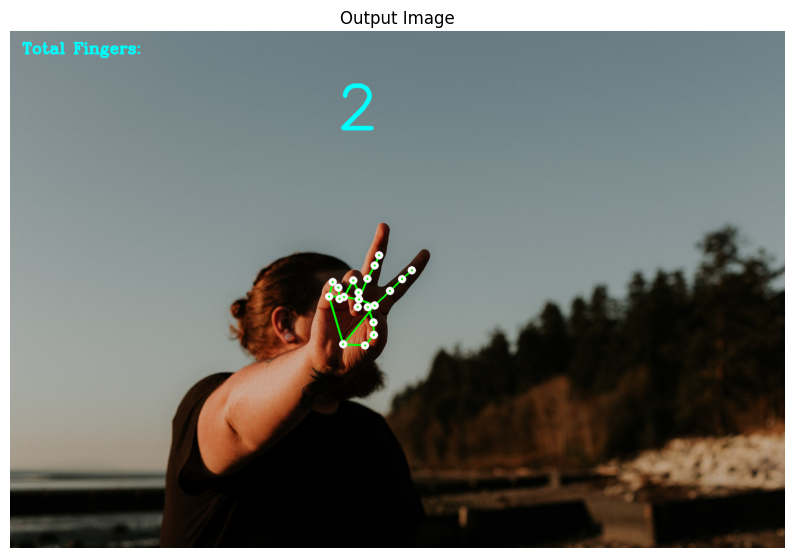

In [16]:
# Read a sample image and perform the hand finger counter on it after flipping it horizontally.
image = cv2.imread('media/sample4.jpg')
flipped_image = cv2.flip(image, 1)
image, results = detectHandsLandmarks(flipped_image, hands, display=False)
if results.multi_hand_landmarks:
    countFingers(image, results)

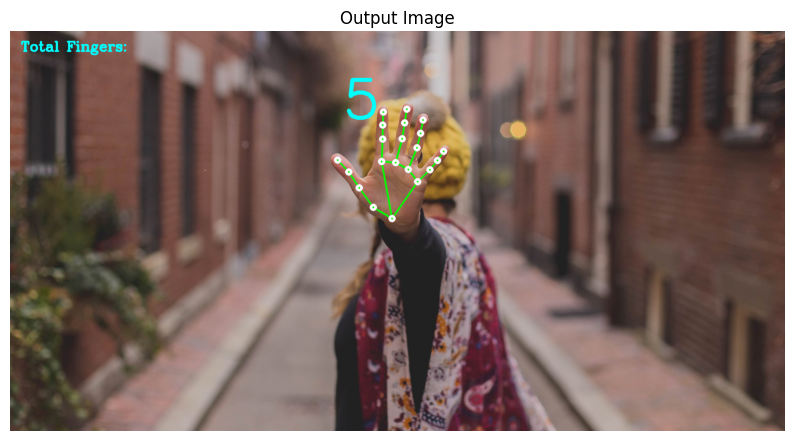

In [17]:
# Read another sample image and perform the hand finger counter on it after flipping it horizontally.
image = cv2.imread('media/sample6.jpg')
flipped_image = cv2.flip(image, 1)
image, results = detectHandsLandmarks(flipped_image, hands, display=False)
if results.multi_hand_landmarks:
    countFingers(image, results)

Nice! seems alright on images. Now lets see how it goes on a webcam feed video in real-time.

In [19]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)

# Again, I will not be using these
#camera_video.set(3,1280)
#camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Hands Fingers Counter', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Perform Hands landmarks detection on the frame.
    frame, results = detectHandsLandmarks(frame, hands_videos, display=False)
    
    # Check if the hands landmarks in the frame are detected.
    if results.multi_hand_landmarks:
        
        # Count of fingers up, and visualize the count on the frame.
        countFingers(frame, results, display=False)
                
    # Display the frame.
    cv2.imshow('Hands Fingers Counter', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()



# Additional comment:
#           - during the time that I tested the hand counter,
#             there was a lot of errors in the detection. 
#             This might be due to my slow computer or it 
#             can also be because of the structure of my hands
#             whenever I close them.
#
#           - My best guess to solve the problem is to remove
#             the buffer frames that has been set. This is because
#             my computer is slow, and it can only run the program
#             on a low FPS. This makes the detection longer and harder.
#
#           - Another assumption of mine for the cause of misdetection 
#             is beucause the lighting of my home and poor camera.
#
#           - In my second attempt, I moved closer to the camera, and 
#             had better lighting.

Cool! working perfectly fine on videos too.

### **<font style="color:rgb(255,140,0)"> Code License Agreement </font>**
```
Copyright (c) 2022 Bleedai.com

Feel free to use this code for your own projects commercial or noncommercial, these projects can be Research-based, just for fun, for-profit, or even Education with the exception that you’re not going to use it for developing a course, book, guide, or any other educational products.

Under *NO CONDITION OR CIRCUMSTANCE* you may use this code for your own paid educational or self-promotional ventures without written consent from Taha Anwar (BleedAI.com).

```
